In [82]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import random

plt.rcParams['font.size']=10
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

# Load profile generation

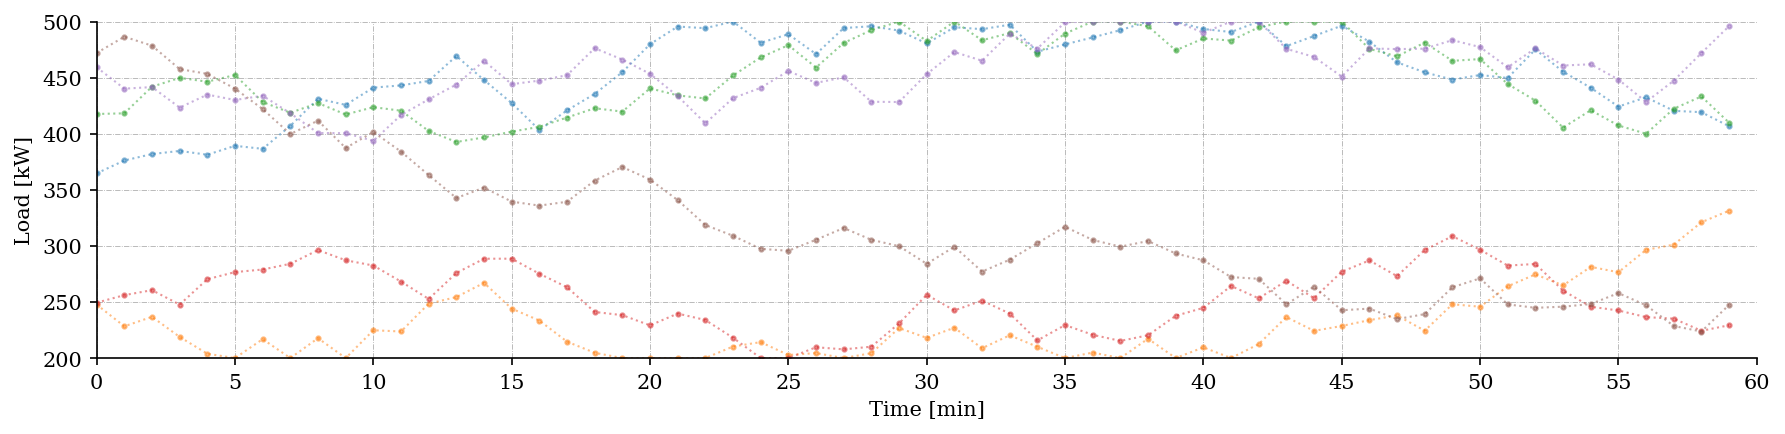

In [87]:
PROFILES = 200
MIN_LOAD = 200
MAX_LOAD = 500
MAX_CONSECUTIVE_DIFF = 25
MINUTES = 60
OMEGA = 50 # sample size

# Generate 200 load profiles for 60 minutes with 1-minute resolution (floats)
# Maximum spacing of -25 kW or 25 kW between two consecutive values

np.random.seed(0) # set seed for reproducibility

load_profiles = []

fig = plt.figure(figsize=(12, 3), dpi=150)

for i in range(PROFILES):
    load_profile = []
    for j in range(MINUTES):
        if j == 0:
            load = np.random.uniform(MIN_LOAD, MAX_LOAD) #first value is sampled from uniform distribution between MIN_LOAD and MAX_LOAD
        else:
            # next value is sampled from uniform distribution between -MAX_CONSECUTIVE_DIFF and MAX_CONSECUTIVE_DIFF 
            # to ensure that the absolute difference between two consecutive values is at most MAX_CONSECUTIVE_DIFF
            load = load_profile[j-1] + np.random.uniform(-MAX_CONSECUTIVE_DIFF, MAX_CONSECUTIVE_DIFF + 1)

            #Ensure that the value is within the bounds after adding the consecutive difference
            if load < MIN_LOAD:
                load = MIN_LOAD
            if load > MAX_LOAD:
                load = MAX_LOAD

        load_profile.append(load) #append the load value for minute j

    load_profiles.append(load_profile) # append the load profile to the list of load profiles

    # Visualize a few load profiles
    if i < 6:
        plt.plot(load_profile, alpha=0.5, linewidth=1, linestyle=':', marker='o', markersize=2)
    
plt.margins(x=0)
plt.xlabel('Time [min]')
plt.ylabel('Load [kW]')
plt.tight_layout()
plt.ylim([MIN_LOAD, MAX_LOAD])
plt.xticks(np.arange(0, 65, 5))

fig.tight_layout()

plt.savefig('Figures/load_profile_generation_small_sample.png', bbox_inches='tight', dpi=300)

plt.show()

Save the load profiles to JSON

In [3]:
consumption_profiles = {}

for i, profile in enumerate(load_profiles):
    consumption_profiles[i] = profile

# with open('Data/ALL_scenarios_consumption.json', 'w') as f:
#     json.dump(consumption_profiles, f)

Statistical analysis

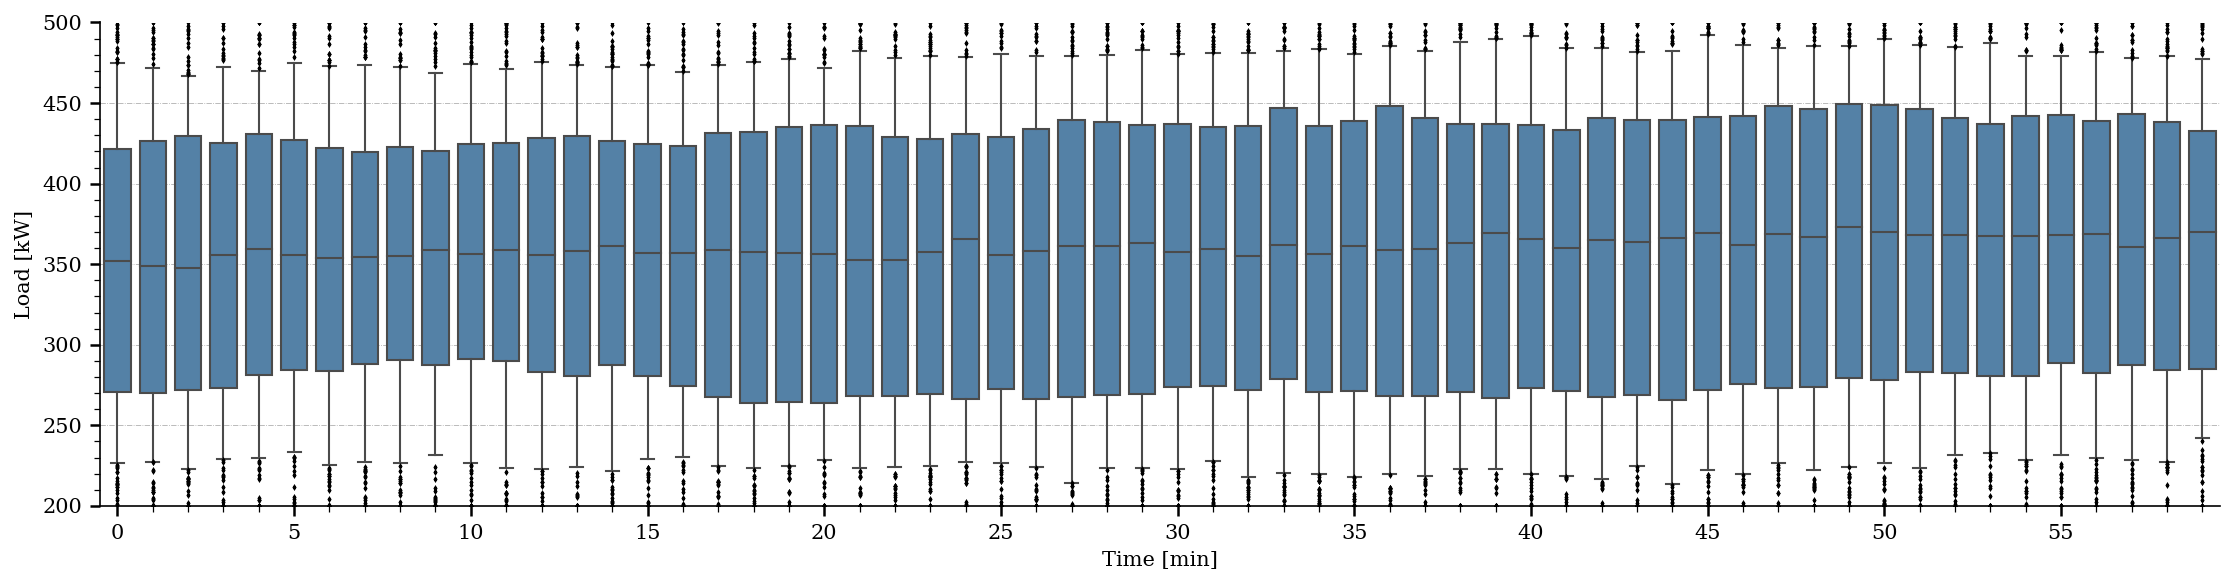

In [88]:
df = pd.DataFrame(load_profiles)
df.index.name = 'Scenario'
df = df.reset_index().melt(id_vars='Scenario', var_name='Minute', value_name='Load')

fig = plt.figure(figsize=(15, 4), dpi=150)

flierprops = dict(marker='d', markersize=1,  markeredgecolor='black')

#Set whiskers to show 10th and 90th percentiles
sns.boxplot(data=df, x='Minute', y='Load', color='steelblue', linewidth=1, whis=[10, 90], flierprops=flierprops, width=0.75)
plt.xlabel('Time [min]')
plt.ylabel('Load [kW]')
plt.tight_layout()
plt.ylim([MIN_LOAD, MAX_LOAD])
plt.xticks(np.arange(0, 65, 5))

plt.minorticks_on()
plt.tick_params(axis='both', which='minor', length=3)
plt.tick_params(axis='both', which='major', length=5, width=1.2)

plt.margins(x=0)
plt.gca().set_axisbelow(True)

fig.tight_layout()

plt.savefig('Figures/boxplot_load_profiles_10th_90th_percentile.png', dpi=500, bbox_inches='tight')
plt.show()


# Step 2 tasks

Read the saved file and get in-sample scenarios

In [89]:
with open('Data/ALL_scenarios_consumption.json', 'r') as f:
    all_scenarios = json.load(f)

S = len(all_scenarios.keys())

random.seed(0)

# Sample scenarios without replacement
in_sample_scenarios = random.sample(range(PROFILES), OMEGA)

print(in_sample_scenarios)
print('Number of samples:' , len(in_sample_scenarios))

scenarios = {}

# Extract sampled scenarios from dictionary containing all scenarios
for i in range(OMEGA):
    scenarios[i] = all_scenarios[str(in_sample_scenarios[i])]

[98, 194, 107, 10, 66, 130, 124, 103, 77, 122, 91, 149, 55, 129, 35, 72, 185, 24, 158, 64, 136, 154, 37, 79, 25, 18, 84, 120, 143, 175, 90, 111, 80, 156, 163, 52, 141, 190, 113, 133, 195, 15, 140, 3, 23, 102, 0, 126, 85, 62]
Number of samples: 50


In [127]:
in_sample_10th_percentile = np.percentile([scenarios[i] for i in range(OMEGA)], 10, axis=0)

## In-sample decision making: Offering strategy under P90 rule

### Method: ALSO-X

In [270]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

m.setParam('OutputFlag', 0)

#============= Variables =============
p_bid_UP = m.addVar(lb=0, ub=gb.GRB.INFINITY, name="p_bid_UP")  # day-ahead upwards reserve bid
y = m.addVars(MINUTES, OMEGA, vtype=gb.GRB.BINARY, name="y")  # binary variable ALSO-X

#============= Objective function =============
# Define objective function

obj = p_bid_UP

m.setObjective(obj, direction)

#============= Constraints =============
M = 1e4 # Big M

m.addConstrs(p_bid_UP - scenarios[w][t] <=  y[t,w] * M for t in range(MINUTES) for w in range(OMEGA))
m.addConstr(gb.quicksum(y[t,w] for t in range(MINUTES) for w in range(OMEGA)) <= 0.10 * MINUTES * OMEGA)

m.addConstr(p_bid_UP >= 0)

#============= Display and run model =============
m.update()
m.optimize()

#============= Results =============

if m.status == gb.GRB.OPTIMAL:
    p_bid_UP_alsoX = p_bid_UP.x
    print('Optimal FCR-D Up bid: %.2f kW' % p_bid_UP.x)

    print('Violated constraints across all minutes and scenarios: %d (maximum allowed is %d)' % (sum(y[t,w].x for t in range(MINUTES) for w in range(OMEGA)), 0.10 * MINUTES * OMEGA))

    print('Runtime: %.5f seconds' % m.Runtime)
else:
    print('No solution found. Status code: %d' % m.status)

Optimal FCR-D Up bid: 241.97 kW
Violated constraints across all minutes and scenarios: 300 (maximum allowed is 300)
Runtime: 1.30900 seconds


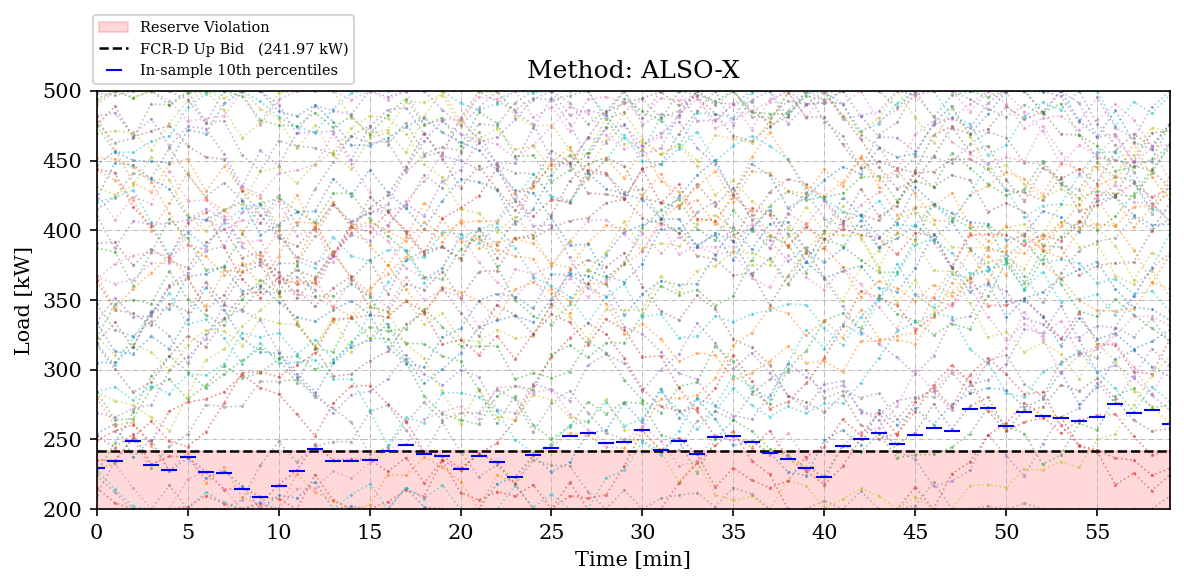

In [273]:
fig = plt.figure(figsize=(8, 4), dpi=150)

plt.fill_between(np.arange(0,60), p_bid_UP_alsoX, color='red', alpha=0.15, label='Reserve Violation')

for i in range(OMEGA):
    plt.plot(scenarios[i], alpha=0.5, linewidth=0.8, linestyle=':', marker='o', markersize=0.6)

plt.axhline(y=p_bid_UP_alsoX, color='black', linestyle='--', label='FCR-D Up Bid   (%.2f kW)' % p_bid_UP_alsoX, linewidth=1.2)

#plot in-sample 10th percentile
plt.plot(in_sample_10th_percentile, label='In-sample 10th percentiles', color='blue', linestyle='', marker='_', markersize=8)

plt.margins(x=0)
plt.xlabel('Time [min]')
plt.ylabel('Load [kW]')
plt.tight_layout()
plt.ylim([MIN_LOAD, MAX_LOAD])
plt.xticks(np.arange(0, 60, 5))
plt.legend(loc = 'lower left', bbox_to_anchor=(-0.01, 1.0), fontsize=7)
plt.title('Method: ALSO-X')

plt.gca().spines[['right','top']].set_visible(True)

fig.tight_layout()

plt.savefig('Figures/FCR_reserves_ALSO-X_IN-sample.png', dpi=300, bbox_inches='tight')

plt.show()

### Method: CVaR

In [276]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

m.setParam('OutputFlag', 0)

#============= Variables =============
p_bid_UP = m.addVar(lb=0, ub=gb.GRB.INFINITY, name="p_bid_UP")  # day-ahead upwards reserve bid
beta = m.addVar(lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="beta")
zeta = m.addVars(MINUTES, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="zeta") 

#============= Objective function =============
# Define objective function

obj = p_bid_UP

m.setObjective(obj, direction)

#============= Constraints =============
m.addConstrs(p_bid_UP - scenarios[w][t] <=  zeta[t,w] for t in range(MINUTES) for w in range(OMEGA))
m.addConstr(1/(MINUTES * OMEGA) * gb.quicksum(zeta[t,w] for t in range(MINUTES) for w in range(OMEGA)) <= (1 - 0.10) * beta)

#Limits
m.addConstr(p_bid_UP >= 0)
m.addConstr(beta <= 0)
m.addConstrs(beta <= zeta[t,w] for t in range(MINUTES) for w in range(OMEGA))

#============= Display and run model =============
m.update()
m.optimize()

#============= Results =============

if m.status == gb.GRB.OPTIMAL:
    p_bid_UP_cvar = p_bid_UP.x
    print('Optimal FCR-D Up bid: %.2f kW' % p_bid_UP.x)

    #Reserve shortfall
    n_violations = 0
    for i in range(len(scenarios)):
        scenario = scenarios[i]
        for t in range(MINUTES):
            if scenario[t] < p_bid_UP_cvar:
                n_violations += 1
    
    print('Violated constraints across all minutes and scenarios: %d (maximum allowed is %d)' % (n_violations, 0.10 * MINUTES * OMEGA))

    print('Runtime: %.5f seconds' % m.Runtime)
else:
    print('No solution found. Status code: %d' % m.status)

Optimal FCR-D Up bid: 216.63 kW
Reserve shortfall: -24.71 kW
Runtime: 0.48900 seconds


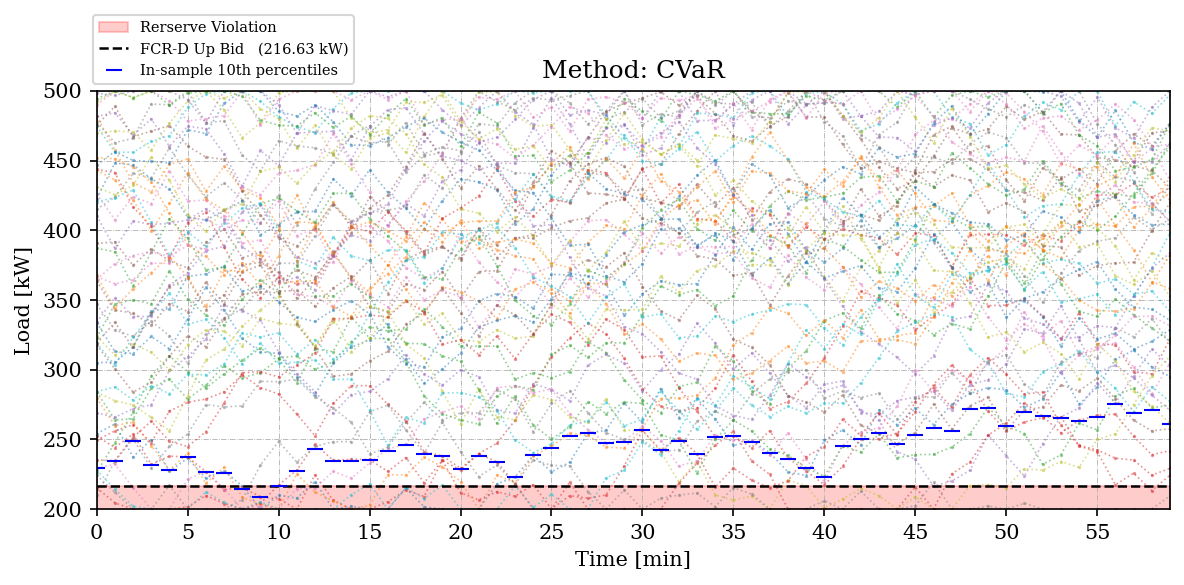

In [274]:
fig = plt.figure(figsize=(8, 4), dpi=150)

plt.fill_between(np.arange(0,60), p_bid_UP_cvar, color='red', alpha=0.2, label='Rerserve Violation')

for i in range(OMEGA):
    plt.plot(scenarios[i], alpha=0.5, linewidth=0.8, linestyle=':', marker='o', markersize=0.6)

plt.axhline(y=p_bid_UP_cvar, color='black', linestyle='--', label='FCR-D Up Bid   (%.2f kW)' % p_bid_UP_cvar, linewidth=1.2)

#plot in-sample 10th percentile
plt.plot(in_sample_10th_percentile, label='In-sample 10th percentiles', color='blue', linestyle='', marker='_', markersize=8)

plt.margins(x=0)
plt.xlabel('Time [min]')
plt.ylabel('Load [kW]')
plt.tight_layout()
plt.ylim([MIN_LOAD, MAX_LOAD])
plt.xticks(np.arange(0, 60, 5))
plt.legend(loc = 'lower left', bbox_to_anchor=(-0.01, 1.0), fontsize=7)
plt.title('Method: CVaR')

plt.gca().spines[['right','top']].set_visible(True)

fig.tight_layout()

plt.savefig('Figures/FCR_reserves_CVaR_IN-sample.png', dpi=300, bbox_inches='tight')

plt.show()

## Out-of-sample analysis

No optimization needed. Simply compare the FCR-D Up bid to the values for each out-of-sample scenario and check for how often the reserve commitment is violated.

In [131]:
# Indices of all scenarios
all_indices = list(range(S))

# Indices of out-of-sample scenarios
out_of_sample_indices = list(set(all_indices) - set(in_sample_scenarios))

# Extract out-of-sample scenarios from the dictionary containing all scenarios
out_sample_scenarios = {}
for i, idx in enumerate(out_of_sample_indices):
    out_sample_scenarios[str(i)] = all_scenarios[str(idx)]

OS = len(out_sample_scenarios.keys())

# Print information
print('Number of out-of-sample scenarios:', len(out_sample_scenarios))

Number of out-of-sample scenarios: 150


In [132]:
n_violations_alsoX = 0
n_violations_cvar = 0

shortfall_magnitude_alsoX = np.zeros(MINUTES * OS)
shortfall_magnitude_cvar = np.zeros(MINUTES * OS)

for i in range(len(out_sample_scenarios)):
    scenario = out_sample_scenarios[str(i)]
    for t in range(MINUTES):
        if scenario[t] < p_bid_UP_alsoX:
            n_violations_alsoX += 1
            shortfall_magnitude_alsoX[i * MINUTES + t] = p_bid_UP_alsoX - scenario[t]
        
        if scenario[t] < p_bid_UP_cvar:
            n_violations_cvar += 1
            shortfall_magnitude_cvar[i * MINUTES + t] = p_bid_UP_cvar - scenario[t]
            

#Average shortfall magnitudes - only consider non-zero values in the arrays
avg_shortfall_magnitude_alsoX = np.mean(shortfall_magnitude_alsoX[shortfall_magnitude_alsoX > 0]) 
avg_shortfall_magnitude_cvar = np.mean(shortfall_magnitude_cvar[shortfall_magnitude_cvar > 0])

print('================== ALSO-X ==================')
print('Average shortfall magnitude: %.2f kW' % avg_shortfall_magnitude_alsoX)
print('Number of violations: %d out of %d (%.2f' % (n_violations_alsoX, MINUTES * len(out_sample_scenarios), n_violations_alsoX / (MINUTES * len(out_sample_scenarios)) * 100) + r'%)')

print('================== CVaR ==================')
print('Average shortfall magnitude: %.2f kW' % avg_shortfall_magnitude_cvar)
print('Number of violations (CVaR): %d out of %d (%.2f' % (n_violations_cvar, MINUTES * len(out_sample_scenarios), n_violations_cvar / (MINUTES * len(out_sample_scenarios)) * 100) + r'%)')

================== ALSO-X ==================
Average shortfall magnitude: 24.77 kW
Number of violations: 1582 out of 9000 (17.58%)
================== CVaR ==================
Average shortfall magnitude: 11.85 kW
Number of violations (CVaR): 764 out of 9000 (8.49%)


* 50 samples might be too few for ALSO-X to be conservative enough to fulfill the requirements.
* The more conservative CVaR method fulfills the requirements, likely due to it also forcing down the shortfall magnitudes.

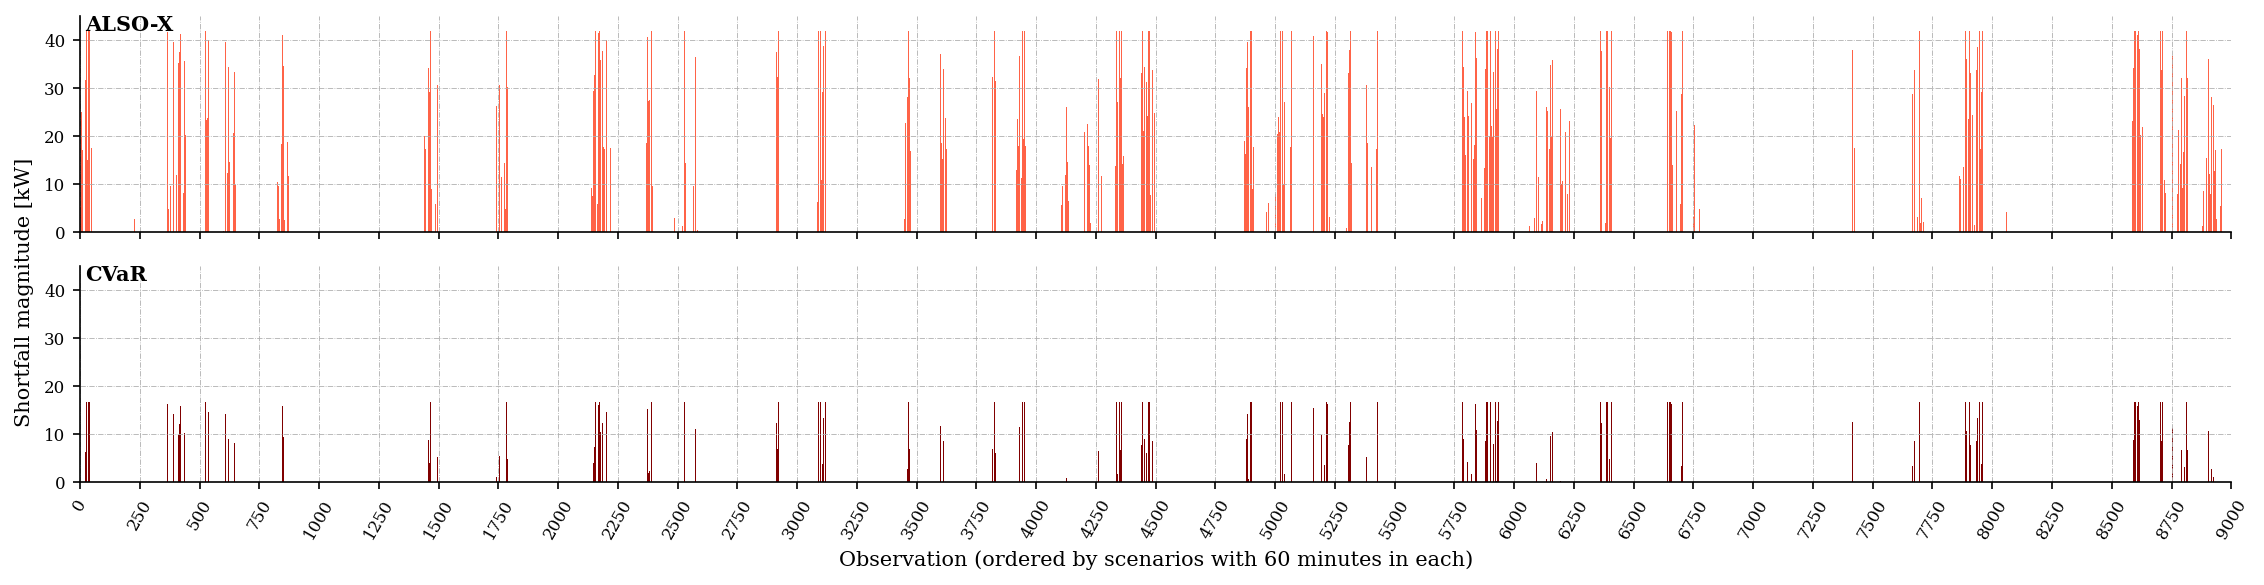

In [141]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 4), dpi=150, sharex=True)

ax1.bar(np.arange(len(shortfall_magnitude_alsoX)), shortfall_magnitude_alsoX, color='tomato', alpha=1)
ax2.bar(np.arange(len(shortfall_magnitude_cvar)), shortfall_magnitude_cvar, color='maroon', alpha=1)

#ax1.axhline(y=avg_shortfall_magnitude_alsoX, color='black', linestyle='-.', linewidth=1, alpha=0.6)
#ax2.axhline(y=avg_shortfall_magnitude_cvar, color='black', linestyle='-.', linewidth=1, alpha=0.6, label='Average magnitude of shortfalls')

#ax2.legend(loc='upper right', fontsize=8)

fig.text(-0.003, 0.5, 'Shortfall magnitude [kW]', va='center', rotation='vertical')

plt.xlabel('Observation (ordered by scenarios with 60 minutes in each)')
ax2.set_xticks(np.arange(0, OS * MINUTES + 250, 250))
ax2.set_xlim([0, OS * MINUTES])

ax1.set_ylim([0,45])
ax2.set_ylim([0,45])

plt.xticks(rotation=60)

ax1.tick_params(axis='both', which='major', labelsize=8)
ax2.tick_params(axis='both', which='major', labelsize=8)

ax1.text(0.0025, 1.005, 'ALSO-X', transform=ax1.transAxes, fontsize=10, verticalalignment='top', color='black', weight='bold')
ax2.text(0.0025, 1.005, 'CVaR', transform=ax2.transAxes, fontsize=10, verticalalignment='top', color='black', weight='bold')

fig.tight_layout()

plt.savefig('Figures/FCR_reserves_out_of_sample_analysis.png', dpi=300, bbox_inches='tight')

plt.show()

#### What would the optimal bid be the 150 out-of-sample scenarios according to ALSO-X?

In [134]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

m.setParam('OutputFlag', 0)

#============= Variables =============
p_bid_UP = m.addVar(lb=0, ub=gb.GRB.INFINITY, name="p_bid_UP")  # day-ahead upwards reserve bid
y = m.addVars(MINUTES, OS, vtype=gb.GRB.BINARY, name="y")  # binary variable ALSO-X

#============= Objective function =============
# Define objective function

obj = p_bid_UP

m.setObjective(obj, direction)

#============= Constraints =============
M = 1e4 # Big M

m.addConstrs(p_bid_UP - out_sample_scenarios[str(w)][t] <=  y[t,w] * M for t in range(MINUTES) for w in range(OS))
m.addConstr(gb.quicksum(y[t,w] for t in range(MINUTES) for w in range(OS)) <= 0.10 * MINUTES * OS)

m.addConstr(p_bid_UP >= 0)

#============= Display and run model =============
m.update()
m.optimize()

#============= Results =============

if m.status == gb.GRB.OPTIMAL:
    print('Optimal FCR-D Up bid: %.2f kW' % p_bid_UP.x)

    print('Violated constraints across all minutes and scenarios: %d (maximum allowed is %d)' % (sum(y[t,w].x for t in range(MINUTES) for w in range(OS)), 0.10 * MINUTES * OS))
else:
    print('No solution found. Status code: %d' % m.status)

Optimal FCR-D Up bid: 220.80 kW
Violated constraints across all minutes and scenarios: 900 (maximum allowed is 900)


* Almost 22 kW less! The sample is therefore not very representative of the 200 scenarios.
* Very close to the one found by CVaR 

#### Analysis - in-sample, out-of-sample vs. full data set

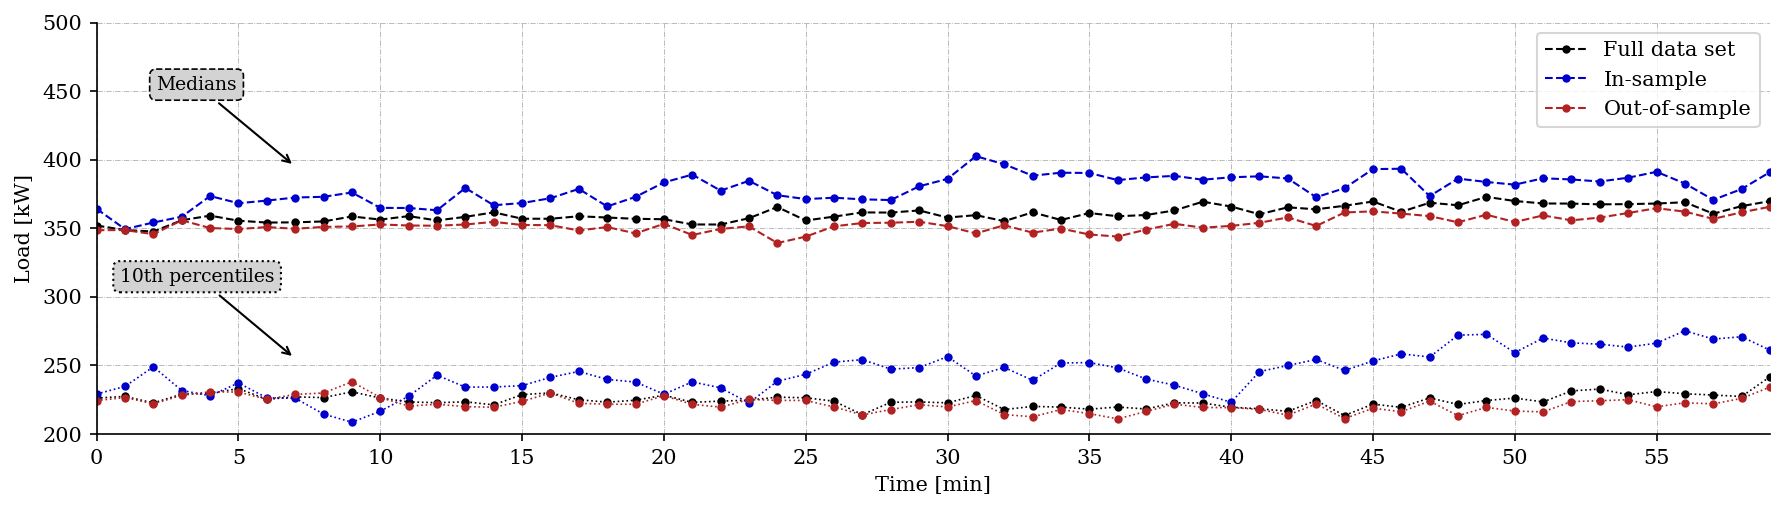

In [224]:
# Get median and 10thpercentiles for both full data set, in-sample values and out-of-sample values

# In-sample
in_sample_median = np.median([scenarios[i] for i in range(OMEGA)], axis=0)
in_sample_lower = np.percentile([scenarios[i] for i in range(OMEGA)], 10, axis=0)

#Out-of-sample
out_sample_median = np.median([out_sample_scenarios[str(i)] for i in range(OS)], axis=0)
out_sample_lower = np.percentile([out_sample_scenarios[str(i)] for i in range(OS)], 10, axis=0)

# Full data set
full_data_median = np.median([consumption_profiles[i] for i in range(PROFILES)], axis=0)
full_data_lower = np.percentile([consumption_profiles[i] for i in range(PROFILES)], 10, axis=0)


#Plot the median and 90% confidence interval for the full data set, in-sample and out-of-sample scenarios
plt.figure(figsize=(12, 3.5), dpi=150)

plt.plot(full_data_median, label='Full data set', color='black', linestyle='--', linewidth=1.0, marker='o', markersize=3)
plt.plot(in_sample_median, label='In-sample', color='mediumblue', linestyle='--', linewidth=1.0, marker='o', markersize=3)
plt.plot(out_sample_median, label='Out-of-sample', color='firebrick', linestyle='--', linewidth=1.0, marker='o', markersize=3)

plt.plot(full_data_lower, color='black', linestyle=':', linewidth=0.8, marker='o', markersize=3)
plt.plot(in_sample_lower, color='mediumblue', linestyle=':', linewidth=0.8, marker='o', markersize=3)
plt.plot(out_sample_lower, color='firebrick', linestyle=':', linewidth=0.8, marker='o', markersize=3)

plt.legend()

# Annotate "Median" above the median lines
plt.gca().annotate('Medians', (7, 395), xytext=(-28, 35), textcoords='offset points', fontsize=9,
            ha='right', va='bottom', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), bbox=dict(boxstyle="round,pad=0.35", fc="lightgrey", ec="black", lw=0.8, linestyle='--', alpha=1))

# Annotate "10th percentiles" above the 10th percentile lines
plt.gca().annotate('10th percentiles', (7, 255), xytext=(-10, 35), textcoords='offset points', fontsize=9,
            ha='right', va='bottom', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), bbox=dict(boxstyle="round,pad=0.35", fc="lightgrey", ec="black", lw=1, linestyle=':', alpha=1))

plt.xlabel('Time [min]')
plt.ylabel('Load [kW]')

plt.ylim([MIN_LOAD, MAX_LOAD])
plt.xticks(np.arange(0, 65, 5))
plt.margins(x=0)

plt.tight_layout()

plt.savefig('Figures/median_10th_percentile_full_in_out_sample.png', dpi=300, bbox_inches='tight')

plt.show()

## Energinet perspective

In [227]:
shortfall_rule_levels = np.arange(0.80,1.01,0.01)
print(shortfall_rule_levels)

[0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]


* For every shortfall rule between 80% and 100%, run ALSO-X for the 50 original samples and get the optimal reserve bid.
* For each of these rules, calculate the expected out-of-sample reserve shortfall in %
* Plot these values against each other to visualize any trade-offs / trends

In [266]:
optimal_bids = {}
shortfalls = {}

for threshold in shortfall_rule_levels:
    print('================================================================')
    print('Running for threshold:', np.round(threshold, 2))

    direction = gb.GRB.MAXIMIZE #Min / Max

    m = gb.Model() # Create a Gurobi model  

    m.setParam('OutputFlag', 0)

    #============= Variables =============
    p_bid_UP = m.addVar(lb=0, ub=gb.GRB.INFINITY, name="p_bid_UP")  # day-ahead upwards reserve bid
    y = m.addVars(MINUTES, OMEGA, vtype=gb.GRB.BINARY, name="y")  # binary variable ALSO-X

    #============= Objective function =============
    # Define objective function

    obj = p_bid_UP

    m.setObjective(obj, direction)

    #============= Constraints =============
    M = 1e4 # Big M

    m.addConstrs(p_bid_UP - scenarios[w][t] <=  y[t,w] * M for t in range(MINUTES) for w in range(OMEGA))
    m.addConstr(gb.quicksum(y[t,w] for t in range(MINUTES) for w in range(OMEGA)) <= (1 - threshold) * MINUTES * OMEGA)

    m.addConstr(p_bid_UP >= 0)

    #============= Display and run model =============
    m.update()
    m.optimize()

    #============= Results =============
    print('---------------------')
    if m.status == gb.GRB.OPTIMAL:
        print('Optimal FCR-D Up bid: %.2f kW' % p_bid_UP.x)

        print('Violated constraints across all minutes and scenarios: %d (maximum allowed is %d)' % (sum(y[t,w].x for t in range(MINUTES) for w in range(OMEGA)), 1 + (1 - threshold) * MINUTES * OMEGA))

        optimal_bids[np.round(threshold, 2)] = p_bid_UP.x
    else:
        print('No solution found. Status code: %d' % m.status)
    
    # ============== Out-of-sample performance =============
    n_violations = 0
    shortfall_magnitude = np.zeros(MINUTES * OS)

    shortfalls[np.round(threshold, 2)] = {}

    for i in range(len(out_sample_scenarios)):
        scenario = out_sample_scenarios[str(i)]
        for t in range(MINUTES):
            if scenario[t] < p_bid_UP.x:
                n_violations += 1
                shortfall_magnitude[i * MINUTES + t] = p_bid_UP.x - scenario[t]

    #Average shortfall magnitudes - only consider non-zero values in the arrays
    if not shortfall_magnitude[shortfall_magnitude > 0].size > 0:
        avg_shortfall_magnitude = 0
    else:
        avg_shortfall_magnitude = np.mean(shortfall_magnitude[shortfall_magnitude > 0]) 

    shortfalls[np.round(threshold, 2)]['Average Magnitude'] = avg_shortfall_magnitude

    try:
        shortfalls[np.round(threshold, 2)]['Violation Frequency Percentage'] = (n_violations / (MINUTES * len(out_sample_scenarios))) * 100
    except:
        shortfalls[np.round(threshold, 2)]['Violation Frequency Percentage'] = 0

    print('\nAverage shortfall magnitude: %.2f kW' % avg_shortfall_magnitude)
    print('Number of violations: %d out of %d (%.2f' % (n_violations, MINUTES * len(out_sample_scenarios), shortfalls[np.round(threshold, 2)]['Violation Frequency Percentage']) + r'%)')

Running for threshold: 0.8
---------------------
Optimal FCR-D Up bid: 281.75 kW
Violated constraints across all minutes and scenarios: 600 (maximum allowed is 600)

Average shortfall magnitude: 46.76 kW
Number of violations: 2641 out of 9000 (29.34%)
Running for threshold: 0.81
---------------------
Optimal FCR-D Up bid: 278.94 kW
Violated constraints across all minutes and scenarios: 570 (maximum allowed is 570)

Average shortfall magnitude: 44.84 kW
Number of violations: 2590 out of 9000 (28.78%)
Running for threshold: 0.82
---------------------
Optimal FCR-D Up bid: 275.06 kW
Violated constraints across all minutes and scenarios: 540 (maximum allowed is 540)

Average shortfall magnitude: 42.51 kW
Number of violations: 2500 out of 9000 (27.78%)
Running for threshold: 0.83
---------------------
Optimal FCR-D Up bid: 271.41 kW
Violated constraints across all minutes and scenarios: 510 (maximum allowed is 510)

Average shortfall magnitude: 40.95 kW
Number of violations: 2378 out of 900

### Visualization

In [229]:
shortfalls.keys()

dict_keys([0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])

In [230]:
shortfalls[0.8].keys()

dict_keys(['Average Magnitude', 'Violation Frequency Percentage'])

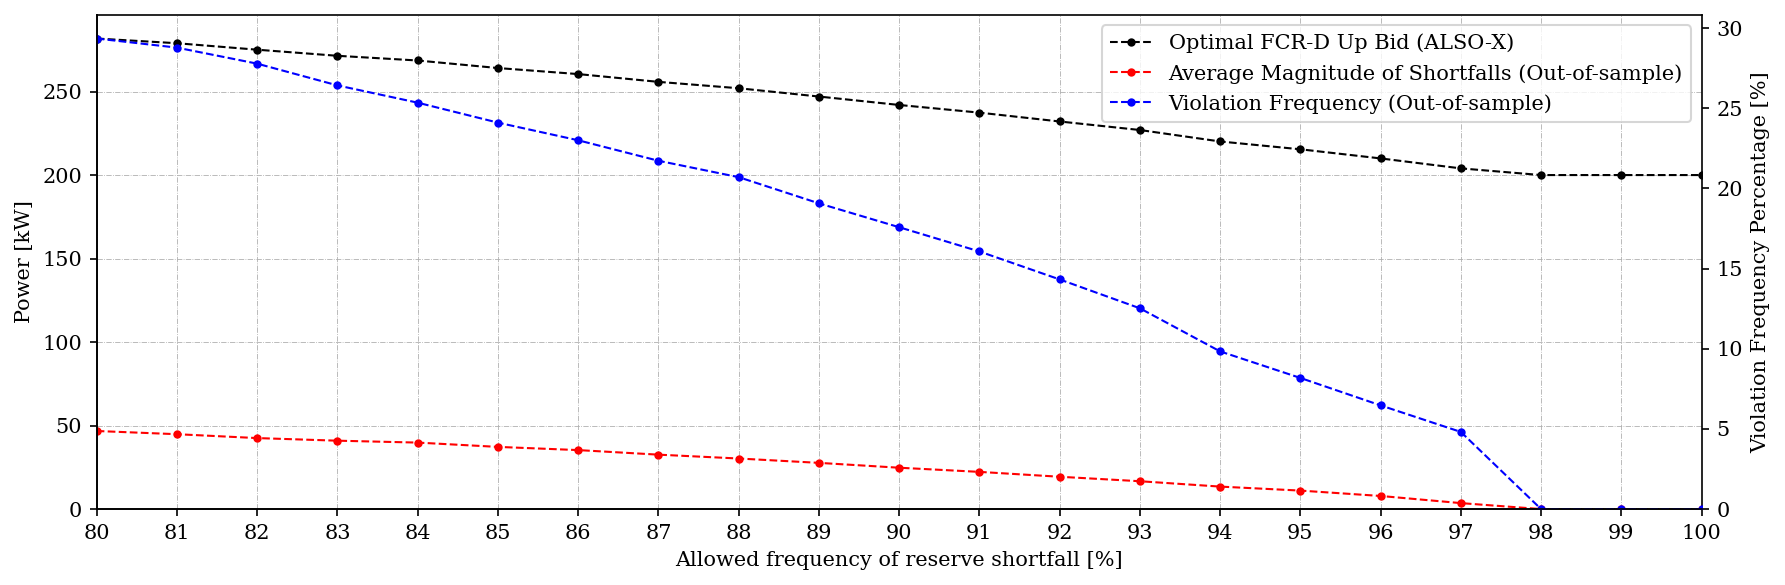

In [269]:
# Plots to answer what he's asking for...

#Twinx with threshold on the x-axis, optimal bids and average shortfall magnitude on one of the y-axes and violation frequency on the other y-axis

fig, ax1 = plt.subplots(figsize=(12, 4), dpi=150)

ax2 = ax1.twinx()

lns1 = ax1.plot(list(optimal_bids.keys()), list(optimal_bids.values()), color='black', linestyle='--', linewidth=1, marker='o', markersize=3, label='Optimal FCR-D Up Bid (ALSO-X)')

ax1.set_xticks(list(optimal_bids.keys()), labels=[str(int(key * 100)) for key in optimal_bids.keys()])

ax1.margins(x=0)

ax1.set_xlabel('Allowed frequency of reserve shortfall [%]')
ax1.set_ylabel('Power [kW]')
ax1.tick_params(axis='y', labelcolor='black')

lns2 = ax1.plot(list(shortfalls.keys()), [shortfalls[key]['Average Magnitude'] for key in shortfalls.keys()], color='red', linestyle='--', linewidth=1, marker='o', markersize=3, label='Average Magnitude of Shortfalls (Out-of-sample)')

lns3 = ax2.plot(list(shortfalls.keys()), [shortfalls[key]['Violation Frequency Percentage'] for key in shortfalls.keys()], color='blue', linestyle='--', linewidth=1, marker='o', markersize=3, label='Violation Frequency (Out-of-sample)')
ax2.set_ylabel('Violation Frequency Percentage [%]')

# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='best')

ax1.spines[['top', 'right']].set_visible(True)
ax2.grid(False)

ax1.set_ylim(ymin=0)
ax2.set_ylim(ymin=0)

fig.tight_layout()

plt.savefig('Figures/ALSO_X_P90_threshold_analysis.png', dpi=300, bbox_inches='tight')

plt.show()